<a href="https://colab.research.google.com/github/VastScientist69/TitanicSurvivalPredictor/blob/main/TitanicSurvivalPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Basic information about the dataset
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset shape: (887, 8)

First 5 rows:
   Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
R

In [2]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values - fill missing ages with median age
if 'Age' in df.columns:
    df['Age'].fillna(df['Age'].median(), inplace=True)

# Create new features - check for correct column names
# The Stanford dataset often uses full names instead of abbreviations
if 'Siblings/Spouses Aboard' in df.columns and 'Parents/Children Aboard' in df.columns:
    df['FamilySize'] = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
elif 'SibSp' in df.columns and 'Parch' in df.columns:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
else:
    print("Warning: Could not find family-related columns")

# Extract title from name
if 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # Simplify titles
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                      'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # Convert titles to numerical
    df['Title'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4})

# Convert categorical variables to numerical
if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

print("\nAfter data cleaning:")
print(df.isnull().sum())
print("\nDataset columns after processing:")
print(df.columns.tolist())

Missing values in each column:
Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

After data cleaning:
Survived                     0
Pclass                       0
Name                         0
Sex                          0
Age                          0
Siblings/Spouses Aboard      0
Parents/Children Aboard      0
Fare                         0
FamilySize                   0
IsAlone                      0
Title                      886
dtype: int64

Dataset columns after processing:
['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare', 'FamilySize', 'IsAlone', 'Title']


<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:22: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3791074317.py:22: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/tmp/ipython-input-3791074317.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


In [3]:
# Determine the correct column names for features
feature_mapping = {
    'Pclass': ['Pclass', 'Passenger Class', 'Class'],
    'Sex': ['Sex', 'Gender'],
    'Age': ['Age'],
    'SibSp': ['SibSp', 'Siblings/Spouses Aboard', 'Siblings-Spouses Aboard'],
    'Parch': ['Parch', 'Parents/Children Aboard', 'Parents-Children Aboard'],
    'Fare': ['Fare', 'Ticket Fare']
}

# Function to find the correct column name
def find_column(possible_names):
    for name in possible_names:
        if name in df.columns:
            return name
    return None

# Prepare features
features = []
for feature, possible_names in feature_mapping.items():
    col_name = find_column(possible_names)
    if col_name:
        features.append(col_name)
        print(f"Using '{col_name}' for {feature}")
    else:
        print(f"Warning: Could not find column for {feature}")

# Add our engineered features
if 'FamilySize' in df.columns:
    features.append('FamilySize')
if 'IsAlone' in df.columns:
    features.append('IsAlone')
if 'Title' in df.columns:
    features.append('Title')

print(f"\nFinal features: {features}")

X = df[features]
y = df['Survived']

Using 'Pclass' for Pclass
Using 'Sex' for Sex
Using 'Age' for Age
Using 'Siblings/Spouses Aboard' for SibSp
Using 'Parents/Children Aboard' for Parch
Using 'Fare' for Fare

Final features: ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare', 'FamilySize', 'IsAlone', 'Title']


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 709
Testing set size: 178


In [5]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [6]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.7640

Confusion Matrix:
[[87 22]
 [20 49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       109
           1       0.69      0.71      0.70        69

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.77      0.76      0.76       178




Feature Importance:
                   feature  importance
2                      Age    0.273694
1                      Sex    0.268009
5                     Fare    0.267705
0                   Pclass    0.080885
6               FamilySize    0.045406
3  Siblings/Spouses Aboard    0.033570
4  Parents/Children Aboard    0.020306
7                  IsAlone    0.010425
8                    Title    0.000000


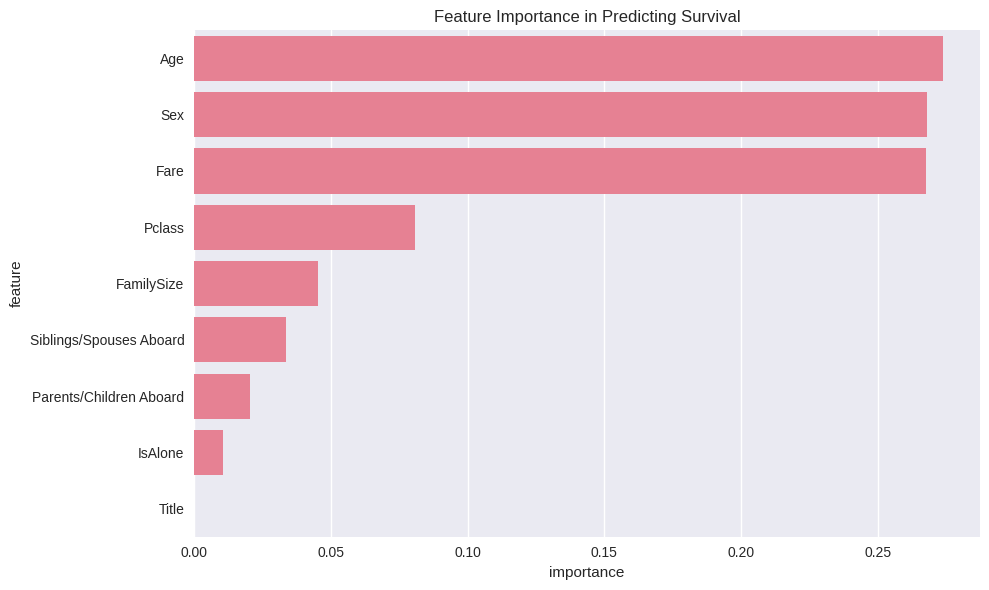

In [7]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Survival')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2457939630.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,1].set_xticklabels(['1st', '2nd', '3rd'])


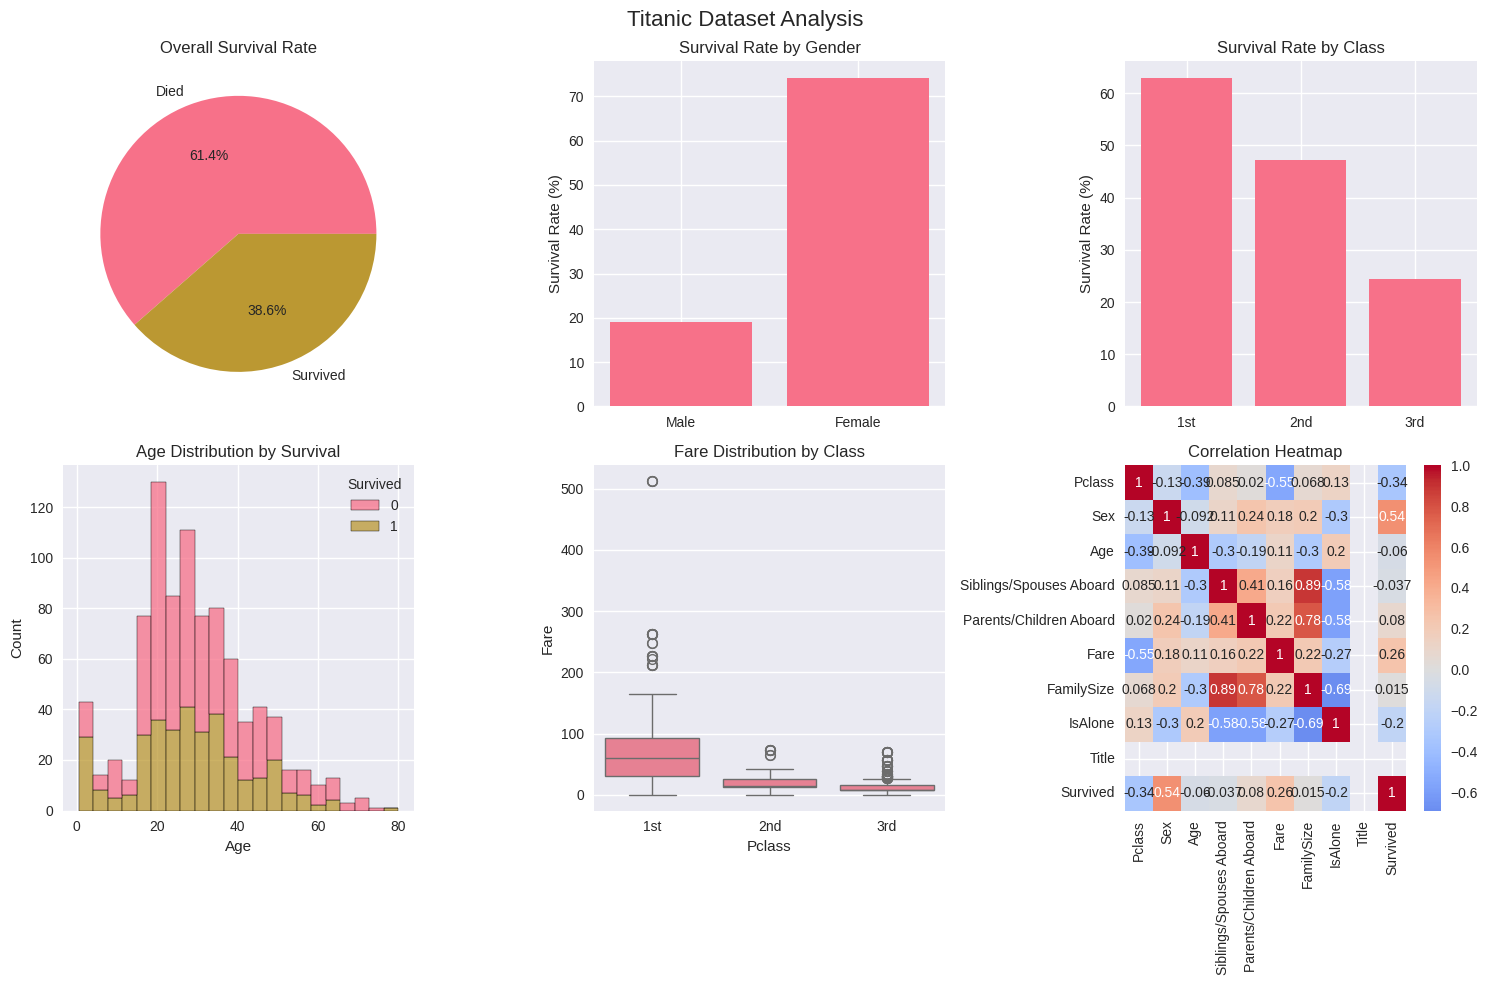

In [8]:
# Set up the plotting layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Titanic Dataset Analysis', fontsize=16)

# 1. Survival rate
survival_rate = df['Survived'].value_counts(normalize=True) * 100
axes[0,0].pie(survival_rate.values, labels=['Died', 'Survived'], autopct='%1.1f%%')
axes[0,0].set_title('Overall Survival Rate')

# 2. Survival by gender
gender_survival = df.groupby('Sex')['Survived'].mean() * 100
axes[0,1].bar(['Male', 'Female'], gender_survival.values)
axes[0,1].set_title('Survival Rate by Gender')
axes[0,1].set_ylabel('Survival Rate (%)')

# 3. Survival by passenger class
class_survival = df.groupby('Pclass')['Survived'].mean() * 100
axes[0,2].bar(['1st', '2nd', '3rd'], class_survival.values)
axes[0,2].set_title('Survival Rate by Class')
axes[0,2].set_ylabel('Survival Rate (%)')

# 4. Age distribution by survival
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', ax=axes[1,0])
axes[1,0].set_title('Age Distribution by Survival')

# 5. Fare distribution by class
sns.boxplot(data=df, x='Pclass', y='Fare', ax=axes[1,1])
axes[1,1].set_title('Fare Distribution by Class')
axes[1,1].set_xticklabels(['1st', '2nd', '3rd'])

# 6. Correlation heatmap
correlation = df[features + ['Survived']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [16]:
# Example: Predict survival for a new passenger
# Get the actual column names from your dataset
pclass_col = find_column(['Pclass', 'Passenger Class', 'Class'])
sex_col = find_column(['Sex', 'Gender'])
age_col = find_column(['Age'])
sibsp_col = find_column(['SibSp', 'Siblings/Spouses Aboard', 'Siblings-Spouses Aboard'])
parch_col = find_column(['Parch', 'Parents/Children Aboard', 'Parents-Children Aboard'])
fare_col = find_column(['Fare', 'Ticket Fare'])

new_passenger_data = {
    pclass_col: [3],           # 3rd class
    sex_col: [0],              # Male
    age_col: [25],             # 25 years old
    sibsp_col: [0],            # No siblings/spouses
    parch_col: [0],            # No parents/children
    fare_col: [7.25],          # Ticket fare
    'FamilySize': [1],         # Traveling alone
    'IsAlone': [0],            # Is alone
    'Title': [0]               # Mr
}

new_passenger = pd.DataFrame(new_passenger_data)
prediction = model.predict(new_passenger)
probability = model.predict_proba(new_passenger)

print(f"Prediction: {'Survived' if prediction[0] == 1 else 'Did not survive'}")
print(f"Probability of survival: {probability[0][1]:.2%}")

Prediction: Did not survive
Probability of survival: 11.27%


In [13]:
# Save the model and cleaned data
import joblib

# Save the trained model
joblib.dump(model, 'titanic_survival_model.pkl')

# Save the cleaned dataset
df.to_csv('titanic_cleaned.csv', index=False)

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

print("Project completed successfully! Files saved:")
print("- titanic_survival_model.pkl (trained model)")
print("- titanic_cleaned.csv (cleaned dataset)")
print("- feature_importance.csv (feature importance analysis)")

Project completed successfully! Files saved:
- titanic_survival_model.pkl (trained model)
- titanic_cleaned.csv (cleaned dataset)
- feature_importance.csv (feature importance analysis)


In [14]:
# Additional insights
print("\nAdditional Insights:")
print(f"Average age: {df['Age'].mean():.2f} years")
print(f"Average fare: ${df['Fare'].mean():.2f}")
print(f"Survival rate by class:\n{class_survival}")
print(f"Survival rate by gender:\n{gender_survival}")
print(f"Survival rate for alone passengers: {df[df['IsAlone'] == 1]['Survived'].mean():.2%}")
print(f"Survival rate for passengers with family: {df[df['IsAlone'] == 0]['Survived'].mean():.2%}")


Additional Insights:
Average age: 29.47 years
Average fare: $32.31
Survival rate by class:
Pclass
1    62.962963
2    47.282609
3    24.435318
Name: Survived, dtype: float64
Survival rate by gender:
Sex
0    19.022688
1    74.203822
Name: Survived, dtype: float64
Survival rate for alone passengers: 30.58%
Survival rate for passengers with family: 50.56%
